In [1]:
from ptm import deepPTM

import pandas as pd
import cloudpickle
import numpy as np

import networkx as nx
from ns.topos.fattree import build as build_fattree

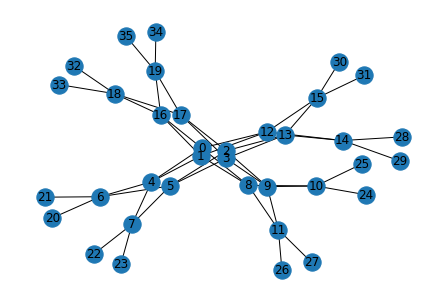

In [12]:
G = build_fattree(4)
nx.draw(G, with_labels=True)

In [3]:
df = pd.read_csv('../data/rsim.csv')

with open('../data/rsim.flow_to_port', 'rb') as f:
    flow_to_port = cloudpickle.load(f)
with open('../data/rsim.port_to_nexthop', 'rb') as f:
    port_to_nexthop = cloudpickle.load(f)

devices = df['cur_hub'].unique()
# Find the devices where there is only a single 

In [25]:
def scrub(df):
    # Takes off the etime
    return df.drop('etime', axis=1)

# First thing to do:
all_devices = pd.unique(df['cur_hub'])
# Filter the trace to only have the `initial` packets.
initial_devices = pd.unique(df['cur_hub'].loc[df['path'].apply(lambda x: "-" not in x)])
device_time_dfs = {d: (0.0, scrub(df.loc[df['cur_hub'] == d])) if d in initial_devices else (0.0, scrub(pd.DataFrame(columns=df.columns))) for d in all_devices}

In [26]:



def to_forwarding_dict(block):
    # Something
    return

block_size = 42 # TODO: Get from spec file
for d in initial_devices:
    t, df = device_time_dfs[d]
    unprocessed = df[df['timestamp'] > t]
    block_to_forward = unprocessed.iloc[:block_size]
    next_t = block_to_forward['timestamp'].iloc[-1]
    # TODO: Preprocess the block
    # TODO: Predict the egress times
    egress_times = np.ones(block_size) * 0.01 # Constant egress time of 0.01 for now.
    updated_block = block_to_forward.copy()

    # Forward the next batch
    forward_dict = to_forwarding_dict(updated_block)


In [27]:
block_size = 42
test_device = 20
t, df = device_time_dfs[test_device]
block = df[df['timestamp'] > t].iloc[:block_size].copy()

def next_hub_(row):
    # Get the next device for this port
    next_hub = port_to_nexthop[test_device][row['cur_port']]
    # next_port = flow_to_port[next_hub][row['flow_id']]
    return next_hub#, next_port

def next_port_(row):
    return flow_to_port[row['cur_hub']][row['flow_id']]

def new_path(row):
    return f"{row['path']}-{row['cur_hub']}_{row['cur_port']}"

# TODO: Can we vectorize these.
block['cur_hub'] = block.apply(next_hub_, axis=1)
block['cur_port'] = block.apply(next_port_, axis=1)
block['path'] = block.apply(new_path, axis=1)

# TODO: Predict the egress times using the trained network.
delays = np.ones(block_size) * 0.01
etimes = block['timestamp'] + delays

# Add the sojourn times to get the updated timestamps
block['timestamp'] = etimes

block

KeyError: 'etime'

In [28]:
(df[df['timestamp'] > t].iloc[:block_size])

,timestamp,pkt_len,cur_hub,cur_port,path,priority,flow_id,scheduler
77,0.002537,1005,20,0,20_0,1.0,31,FIFO
83,0.002725,1015,20,0,20_0,1.0,63,FIFO
132,0.004307,1006,20,0,20_0,1.0,14,FIFO
161,0.004840,1023,20,0,20_0,1.0,54,FIFO
198,0.005502,1000,20,0,20_0,1.0,10,FIFO
256,0.008108,1001,20,0,20_0,1.0,14,FIFO
267,0.008365,1044,20,0,20_0,1.0,55,FIFO
310,0.009243,981,20,0,20_0,1.0,68,FIFO
313,0.009280,973,20,0,20_0,1.0,54,FIFO
377,0.010668,990,20,0,20_0,1.0,52,FIFO


In [7]:
flow_to_port[0]

{2: 0, 10: 0, 14: 0, 31: 0, 48: 0, 52: 0, 54: 0, 55: 0, 63: 0, 68: 0}

In [8]:
port_to_nexthop[test_device]

{0: 6}

In [13]:
flow_to_port[0]

{1: 1,
 4: 3,
 12: 0,
 16: 2,
 22: 2,
 29: 1,
 30: 0,
 35: 1,
 46: 1,
 60: 2,
 64: 2,
 65: 0,
 69: 2,
 80: 0,
 85: 3,
 94: 0}

In [35]:
def numpy_ewma_vectorized(data, alpha):
    # alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]
    pows = alpha_rev**(np.arange(n+1))
    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)
    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

In [37]:
a = np.array([0, 1, 2, 3, 4, 5])
numpy_ewma_vectorized(a, 0.8)

array([0.     , 0.8    , 1.76   , 2.752  , 3.7504 , 4.75008])